## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

df.price = np.log1p(df.price)
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

del df_train['price']
del df_val['price']
del df_test['price']

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Now, use `DictVectorizer` to turn train and validation into matrices:

In [4]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [5]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_text, plot_tree

dt= DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

In [6]:
print(export_text(dt))

|--- feature_12 <= 0.50
|   |--- value: [4.29]
|--- feature_12 >  0.50
|   |--- value: [5.15]



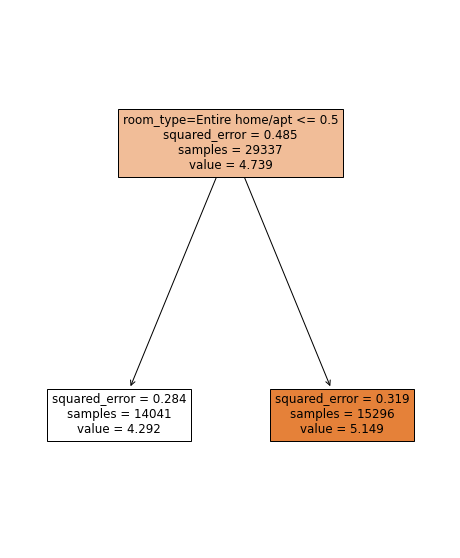

In [7]:
fig = plt.figure(figsize=(8,10))
_ = plot_tree(dt, feature_names=dv.feature_names_, filled=True)

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

Ans: room_type

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("RMSE on validation:", rmse)

RMSE on validation: 0.46156323035140573


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

Ans: 0.459

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [9]:
scores =[]
for n in range(10,201,10):
    
    rf = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)
    rf.fit(X_train,y_train)

    y_pred = rf.predict(X_val)
    scores.append((n, np.sqrt(mean_squared_error(y_val, y_pred))))

In [10]:
df_scores = pd.DataFrame(scores, columns=['n_estimator', 'rmse'])

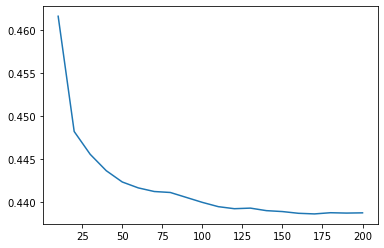

In [11]:
plt.plot(df_scores.n_estimator, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

Ans: 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [12]:
scores =[]
for max_depth in range(10,26,5):
    for n in range(10,201,10):

        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train,y_train)

        y_pred = rf.predict(X_val)
        scores.append((n, max_depth, np.sqrt(mean_squared_error(y_val, y_pred))))

In [13]:
df_scores = pd.DataFrame(scores, columns=['n_estimator','max_depth','rmse'])

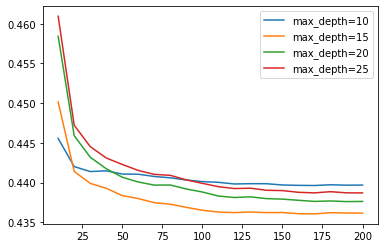

In [14]:
for d in range(10, 26, 5):
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimator, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Ans: We need low rmse, `max_depth=15` is the best choice. 

Bonus question (not graded):

Will the answer be different if we change the seed for the model?
 **Yes,** It will be different

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [15]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [16]:
dv.feature_names_[np.argmax(rf.feature_importances_)]

'room_type=Entire home/apt'

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`


Ans: `room_type=Entire home/apt`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [17]:
import xgboost as xgb

In [28]:
%%capture output

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                 evals=watchlist, verbose_eval=5)

In [29]:
out= output.stdout

print(out)

[0]	train-rmse:3.02751	val-rmse:3.02415
[5]	train-rmse:0.67490	val-rmse:0.67752
[10]	train-rmse:0.43912	val-rmse:0.44981
[15]	train-rmse:0.42259	val-rmse:0.43827
[20]	train-rmse:0.41716	val-rmse:0.43691
[25]	train-rmse:0.41365	val-rmse:0.43621
[30]	train-rmse:0.40712	val-rmse:0.43542
[35]	train-rmse:0.40444	val-rmse:0.43510
[40]	train-rmse:0.40103	val-rmse:0.43466
[45]	train-rmse:0.39723	val-rmse:0.43371
[50]	train-rmse:0.39446	val-rmse:0.43384
[55]	train-rmse:0.39129	val-rmse:0.43378
[60]	train-rmse:0.38743	val-rmse:0.43404
[65]	train-rmse:0.38421	val-rmse:0.43450
[70]	train-rmse:0.38117	val-rmse:0.43467
[75]	train-rmse:0.37801	val-rmse:0.43489
[80]	train-rmse:0.37668	val-rmse:0.43526
[85]	train-rmse:0.37259	val-rmse:0.43537
[90]	train-rmse:0.36998	val-rmse:0.43539
[95]	train-rmse:0.36742	val-rmse:0.43579
[99]	train-rmse:0.36478	val-rmse:0.43621



In [30]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [31]:
df_score = parse_xgb_output(output)

0.43371


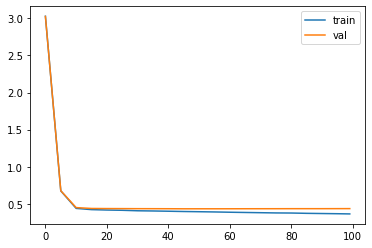

In [32]:
plt.plot(df_score.num_iter, df_score.train_rmse, label='train')
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.legend()
print(np.min(df_score.val_rmse))

Now change `eta` first to `0.1` and then to `0.01`

In [33]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                 evals=watchlist, verbose_eval=5)

0.4325


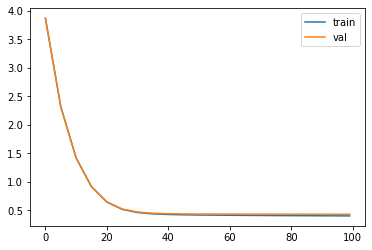

In [34]:
df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_rmse, label='train')
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.legend()
print(np.min(df_score.val_rmse))

In [ ]:
%%capture output


xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}


model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                 evals=watchlist, verbose_eval=5)

1.63045


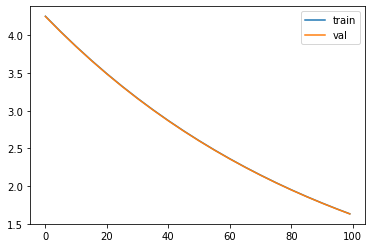

In [26]:
df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_rmse, label='train')
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.legend()

print(np.min(df_score.val_rmse))

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01


Ans : `eta = 0.1` leads to the best RMSE score on validation data

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

